In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


# Load the cleaned datasets
df_income = pd.read_csv("../data/clean/income_statement_data.csv", sep=";", encoding="utf-8")
df_ma = pd.read_csv("../data/clean/mergers_acquisitions_data.csv", sep=";", encoding="utf-8")
df_profile = pd.read_csv("../data/clean/profile_data.csv", sep=";", encoding="utf-8")
df_stock = pd.read_csv("../data/clean/stock_data.csv", sep=";", encoding="utf-8")

## Initial Data Exploration

In [13]:
print(df_income.info()) 
print(df_ma.info())
print(df_profile.info())
print(df_stock.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   statement_date   25 non-null     object 
 1   symbol           25 non-null     object 
 2   revenue          25 non-null     int64  
 3   grossProfit      25 non-null     int64  
 4   operatingIncome  25 non-null     int64  
 5   netIncome        25 non-null     int64  
 6   eps              25 non-null     float64
dtypes: float64(1), int64(4), object(2)
memory usage: 1.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   acquisition_date                90 non-null     object 
 1   acquisition_type                90 non-null     object 
 2   acquired_company                90 non-null     object 
 3   acqu

In [15]:
print(df_income.isnull().sum())
print(df_ma.isnull().sum())
print(df_profile.isnull().sum())
print(df_stock.isnull().sum())

statement_date     0
symbol             0
revenue            0
grossProfit        0
operatingIncome    0
netIncome          0
eps                0
dtype: int64
acquisition_date                  0
acquisition_type                  0
acquired_company                  0
acquired_company_domain           0
acquirer                          0
acquisition_price_usd             0
is_key_acquisition                0
founded_year                      0
company_details_overview          0
disclosed                         0
industry                          0
acquisition_year                  0
matured                           0
acquisition_price_usd_billions    0
acquired_company_size             0
city                              0
state_province_region             0
country                           0
dtype: int64
symbol               0
companyName          0
industry             0
sector               0
mktCap               0
ceo                  0
country              0
fullTimeEmployees 

In [17]:
print(df_income.describe())
print(df_ma.describe())
print(df_stock.describe())

            revenue   grossProfit  operatingIncome     netIncome        eps
count  2.500000e+01  2.500000e+01     2.500000e+01  2.500000e+01  25.000000
mean   1.106089e+11  8.055976e+10     4.416832e+10  2.494272e+10  25.068000
std    1.248166e+11  8.678377e+10     7.239439e+10  3.140509e+10  17.996219
min    1.170300e+10  8.266000e+09    -1.305400e+10 -2.281900e+10 -10.360000
25%    1.785900e+10  1.151900e+10     6.275000e+09  4.932000e+09   9.710000
50%    4.736500e+10  4.736500e+10     1.348600e+10  9.459000e+09  23.050000
75%    1.456700e+11  1.231960e+11     5.569300e+10  4.252100e+10  38.760000
max    3.714330e+11  3.714330e+11     3.457910e+11  9.622300e+10  61.900000
       acquisition_price_usd  founded_year  disclosed  acquisition_year  \
count           9.000000e+01     90.000000       90.0         90.000000   
mean            4.967620e+09   1974.988889        1.0       2011.377778   
std             9.056168e+09     40.280057        0.0          8.276918   
min             

In [19]:
df_ma['industry'].value_counts()

industry
Investment & Financial Services    8
Technology & Software              8
Medical & Healthcare               7
Insurance                          6
Food & Beverage                    5
Financial Services                 5
Manufacturing                      5
Automotive & Transportation        4
Energy                             4
Media & Entertainment              4
Retail                             4
Aerospace & Aviation               3
Building & Materials               3
Logistics & Fleet Management       2
Telecommunications                 2
Cybersecurity                      2
Security Services                  1
Diversified Industrial             1
Reinsurance                        1
Agriculture & Farming Equipment    1
Housing & Real Estate              1
Chemical Manufacturing             1
Trade & Supply Chain Management    1
Facility Services                  1
Education                          1
Construction Equipment             1
Cosmetics & Personal Care    

In [21]:
#Add symbol to df_ma

companies = {
    "BlackRock": "BLK",
    "Berkshire Hathaway": "BRK-B",
    "Goldman Sachs": "GS",
    "JPMorgan Chase": "JPM",
    "State Street": "STT"
}

df_ma['symbol'] = df_ma['acquirer'].map(companies)

In [23]:
df_ma["acquisition_date"] = pd.to_datetime(df_ma["acquisition_date"], errors="coerce", format='mixed')
df_ma["acquisition_price_usd"] = (df_ma["acquisition_price_usd"].astype(float))
df_ma['founded_year'] = df_ma['founded_year'].astype(int)
df_ma['is_key_acquisition'] = df_ma['is_key_acquisition'].astype(bool)

## Acquisition Trends & Patterns

### How often does BlackRock acquire companies?

In [ ]:
df_ma['year'] = df_ma['acquisition_date'].dt.year

plt.figure(figsize=(12, 6))
sns.countplot(data=df_ma, x="year", hue="acquirer", palette="tab10")

plt.xlabel("Year")
plt.ylabel("Number of Mergers & Acquisitions")
plt.title("M&A Activity Over Time by Acquirer")
plt.xticks(rotation=45)
plt.legend(title="Acquirer", bbox_to_anchor=(1, 1))  # Move legend outside
plt.show()

### Does blackrock & its competitors prefer matured companies?

In [ ]:
# Group by acquirer and maturity status, then count occurrences
maturity_counts = df_ma.groupby(["acquirer", "matured"]).size().unstack()

# Create a stacked bar chart
maturity_counts.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="tab10")

# Add labels and title
plt.xlabel("Acquirer")
plt.ylabel("Number of Acquisitions")
plt.title("Preference for Matured vs. Non-Matured Companies by Acquirer")
plt.legend(["Not Matured (<10 years)", "Matured (10+ years)"], title="Company Age at Acquisition")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show plot
plt.show()

### What Industries does BlackRock and its competitors invest in the most?

In [ ]:
plt.figure(figsize=(10, 8))

# Create a grouped pie chart (one per acquirer)
for acquirer in df_ma["acquirer"].unique():
    plt.figure(figsize=(8, 8))
    df_subset = df_ma[df_ma["acquirer"] == acquirer]
    industry_counts = df_subset['industry'].value_counts()
    industry_counts.plot(kind='bar')
    
    plt.title(f"Industry Distribution of Acquisitions for {acquirer}")
    plt.xlabel('Industry')
    plt.ylabel('Number of Acquisitions')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.show()

### What's the typical acquisition value?

In [ ]:
df_ma['acquisition_price_usd_billions'] = df_ma['acquisition_price_usd'] / 1e9

cross_table = df_ma.groupby("acquirer", as_index=False)["acquisition_price_usd_billions"].mean()

plt.figure(figsize=(10, 6))
sns.barplot(x="acquirer", y="acquisition_price_usd_billions", data=cross_table, palette="tab10")
plt.title("Average Acquisition Price by Acquirer")
plt.xlabel("Acquirer")
plt.ylabel("Average Acquisition Price (in billion USD)")
plt.xticks(rotation=45)

plt.show()

### What are the top 3 acquired companies by acquisition price?

In [ ]:
acquirer_table = df_ma.groupby(['acquirer', 'acquired_company', 'acquisition_year'], as_index=False)['acquisition_price_usd_billions'].sum()
# Select the top 3 acquisitions for each acquirer
top_acquisitions_per_acquirer = acquirer_table.groupby("acquirer").apply(lambda x: x.nlargest(3, "acquisition_price_usd_billions")).reset_index(drop=True)

# Create bar plot
plt.figure(figsize=(14, 7))
ax = sns.barplot(data=top_acquisitions_per_acquirer, 
                 x="acquisition_price_usd_billions", 
                 y="acquired_company", 
                 hue="acquirer", 
                 palette="tab10")

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Add labels and title
plt.title("Top 3 Acquisitions by Acquirer")
plt.xlabel("Acquisition Price (in Billion USD)")
plt.ylabel("Acquired Company")

# Add value labels to bars with the acquisition date
for p, (_, row) in zip(ax.patches, top_acquisitions_per_acquirer.iterrows()):
    width = p.get_width()  # Get bar width
    if width > 0:  # Only annotate if there's data
        acquisition_date = row["acquisition_year"]
        ax.annotate(f"${width:,.2f}B ({acquisition_date})",  
                    (p.get_x() + width + 0.2, p.get_y() + p.get_height() / 2),  
                    ha='left', va='center', fontsize=9, fontweight='bold', color='black')

# Show legend
plt.legend(title="Acquirer", bbox_to_anchor=(1, 1))

# Display plot
plt.show()

### Who has the most deployed capital?

In [ ]:
acquirer_table = df_ma.groupby('acquirer', as_index=False)['acquisition_price_usd_billions'].agg('sum')

plt.figure(figsize=(10, 6))
sns.barplot(x="acquirer", y="acquisition_price_usd_billions", data=acquirer_table, palette="tab10")
plt.title("Acquisition Price by Acquirer")
plt.xlabel("Acquirer")
plt.ylabel("Acquisition Price (in billion USD)")
plt.xticks(rotation=45)

plt.show()

## Financial Strategy & Spending

### Is there a relationship between net income and M&A spending?

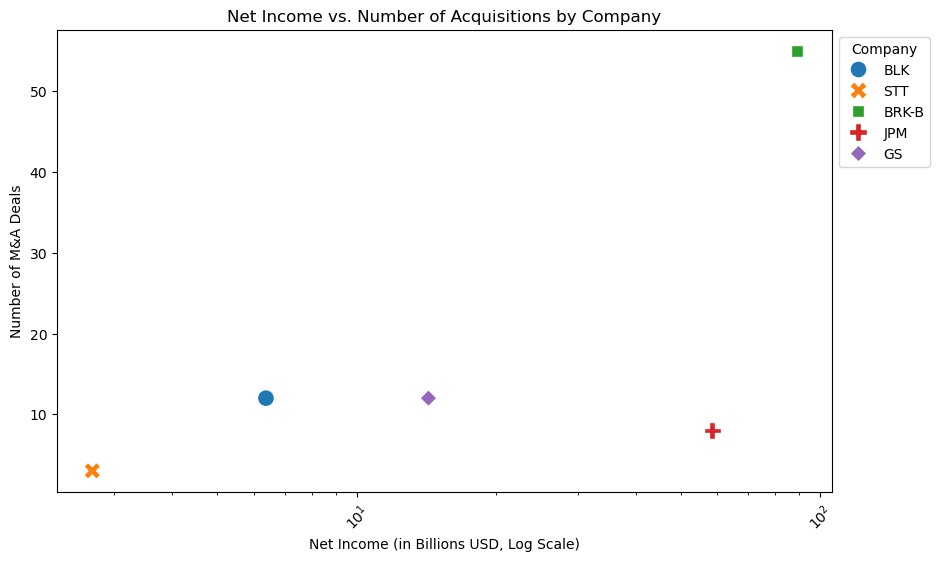

In [34]:
ma_counts = df_ma.groupby("symbol").size().reset_index(name="num_acquisitions")

#drop duplicates to show only one mark in the graph
df_income_latest = df_income.sort_values(by="statement_date", ascending=False).drop_duplicates(subset=["symbol"])

df_merged = pd.merge(df_income_latest, ma_counts, left_on="symbol", right_on="symbol", how="left")
df_merged.fillna(0, inplace=True)

df_merged["netIncome_billion"] = df_merged["netIncome"] / 1e9

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_merged, 
    x="netIncome_billion", 
    y="num_acquisitions", 
    hue="symbol",  
    style="symbol",  
    palette="tab10",  
    s=150  
)

plt.xscale("log")

plt.title("Net Income vs. Number of Acquisitions by Company")
plt.xlabel("Net Income (in Billions USD, Log Scale)")
plt.ylabel("Number of M&A Deals")
plt.xticks(rotation=45)
plt.legend(title="Company", bbox_to_anchor=(1, 1))  

plt.show()

### Are matured companies more expensive?

/var/folders/pv/mkxvrtmj3p531hhmkxtn40tw0000gn/T/ipykernel_77056/1281349629.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_price_per_maturity.index, y=avg_price_per_maturity.values, palette="coolwarm")


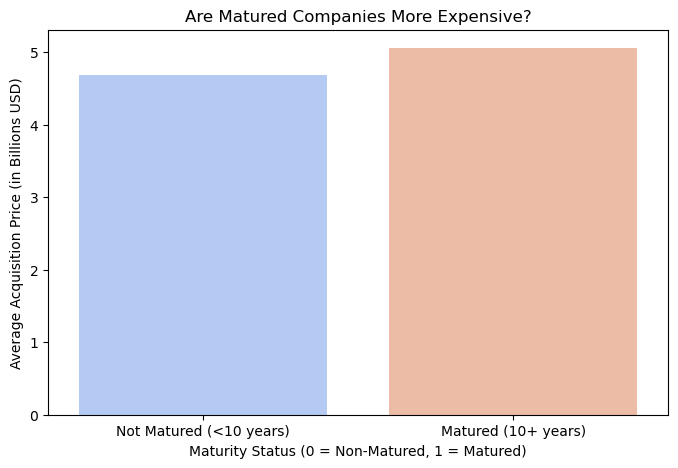

In [27]:
avg_price_per_maturity = df_ma.groupby("matured")["acquisition_price_usd_billions"].mean()

# Create a bar plot
plt.figure(figsize=(8, 5))
sns.barplot(x=avg_price_per_maturity.index, y=avg_price_per_maturity.values, palette="coolwarm")

# Add labels
plt.xlabel("Maturity Status (0 = Non-Matured, 1 = Matured)")
plt.ylabel("Average Acquisition Price (in Billions USD)")
plt.title("Are Matured Companies More Expensive?")
plt.xticks([0, 1], ["Not Matured (<10 years)", "Matured (10+ years)"])

# Show plot
plt.show()

### How does BlackRock's M&A spending compare to its market cap?
do they make acquisition relative to their financial strength?

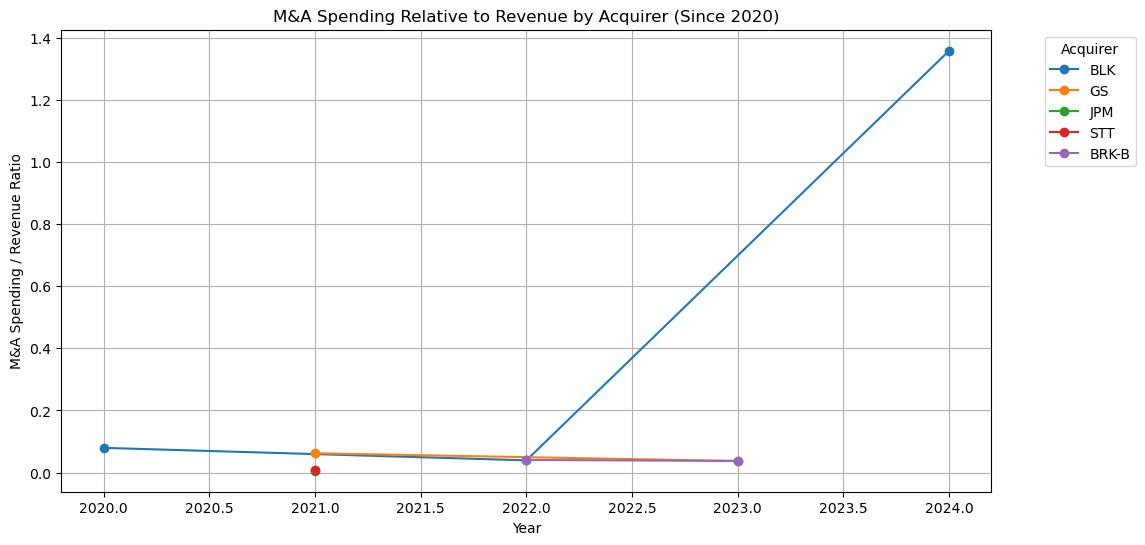

In [30]:
# Ensure acquisition price is numeric and convert to billions
df_ma["acquisition_price_usd"] = pd.to_numeric(df_ma["acquisition_price_usd"], errors="coerce")
df_ma["acquisition_price_usd_billions"] = df_ma["acquisition_price_usd"] / 1e9

# Filter acquisitions from 2020 onwards
df_ma_recent = df_ma[df_ma["acquisition_year"] >= 2020]

# Aggregate M&A spending by year and acquirer
ma_spending_by_year = df_ma_recent.groupby(["acquisition_year", "symbol"])["acquisition_price_usd_billions"].sum().reset_index()
ma_spending_by_year.columns = ["year", "symbol", "total_ma_spending_billion"]

# Ensure revenue is numeric and convert to billions
df_income["revenue_billion"] = df_income["revenue"] / 1e9

# Extract financials for relevant years
df_income['statement_date'] = pd.to_datetime(df_income["statement_date"], errors="coerce", format='mixed')
financials_by_acquirer = df_income.groupby(["symbol", df_income["statement_date"].dt.year])["revenue_billion"].mean().reset_index()
financials_by_acquirer.columns = ["symbol", "year", "revenue_billion"]

# Merge M&A spending with revenue for all acquirers
df_analysis = ma_spending_by_year.merge(financials_by_acquirer, on=["year", "symbol"], how="left")

# Compute key ratio: M&A Spending / Revenue
df_analysis["ma_spending_to_revenue"] = df_analysis["total_ma_spending_billion"] / df_analysis["revenue_billion"]

# Plot trends with multiple acquirers
plt.figure(figsize=(12, 6))
for acquirer in df_analysis["symbol"].unique():
    subset = df_analysis[df_analysis["symbol"] == acquirer]
    plt.plot(subset["year"], subset["ma_spending_to_revenue"], marker="o", label=acquirer)

plt.title("M&A Spending Relative to Revenue by Acquirer (Since 2020)")
plt.xlabel("Year")
plt.ylabel("M&A Spending / Revenue Ratio")
plt.legend(title="Acquirer", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)
plt.show()

1️⃣ BlackRock (BLK) Shows a Significant Spike in 2024

BlackRock's M&A spending relative to revenue skyrockets in 2024.
This suggests that in 2024, BlackRock allocated a significantly larger portion of its revenue to M&A compared to previous years.
Possible reasons:
A large acquisition in 2024.
A strategic shift in BlackRock’s investment approach.

2️⃣ Berkshire Hathaway (BRK-B) Maintains a More Stable Trend

Berkshire Hathaway doesn’t show extreme fluctuations, maintaining a steady low M&A-to-revenue ratio.
This suggests a more cautious or diversified investment approach, where M&A spending is proportional to its revenue.

3️⃣ Goldman Sachs (GS) and JPMorgan Chase (JPM) Have Consistently Low Ratios

These companies have much lower M&A spending relative to revenue.
This could mean:
They prefer organic growth rather than aggressive acquisitions.
They make acquisitions in smaller deal sizes.
Their core business model is different, focusing on investment banking and financial services rather than heavy M&A activity.

4️⃣ State Street (STT) Shows Minimal M&A Activity

State Street barely registers on the graph, indicating limited M&A investments relative to revenue.
Likely explanation:
They prioritize other growth strategies (e.g., asset management expansion, technology investments).
They have fewer opportunities or a lower-risk appetite for M&A

### Stock Price Comparison

/var/folders/pv/mkxvrtmj3p531hhmkxtn40tw0000gn/T/ipykernel_77056/4125385164.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df_stock_latest, x="symbol", y="price", palette="tab10")


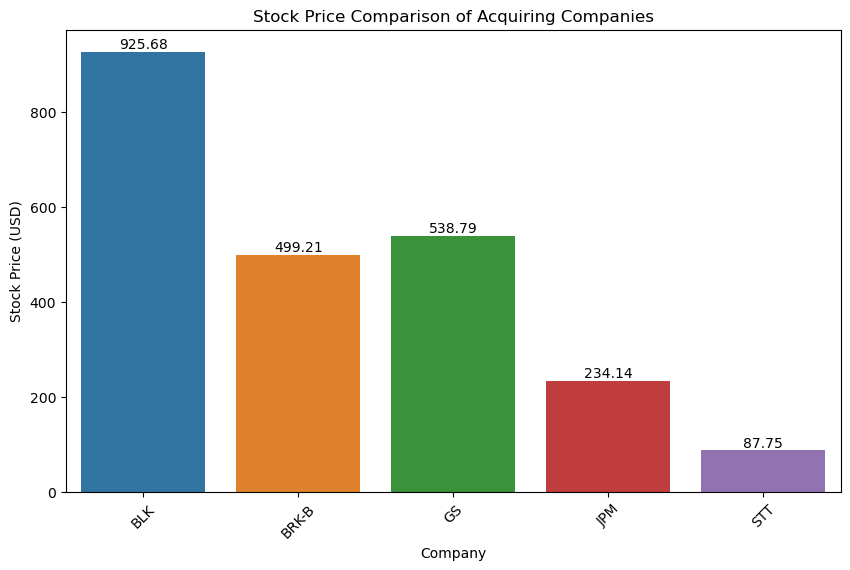

In [32]:
df_stock_latest = df_stock.groupby("symbol", as_index=False)["price"].mean()
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df_stock_latest, x="symbol", y="price", palette="tab10")
for p in ax.patches:
    ax.annotate(f"{p.get_height():,.2f}", 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=10, color='black')

plt.title("Stock Price Comparison of Acquiring Companies")
plt.xlabel("Company")
plt.ylabel("Stock Price (USD)")
plt.xticks(rotation=45)

plt.show()

In [ ]:
# Plotting scatter plots for each numerical column against 'NetIncome' to visualize their relationships
df_numerical = df_ma.select_dtypes(include='number')

for col in df_numerical.columns:
    if col != "acquisition_price_usd_billions" and col != "acquisition_price_usd":
        plt.figure(figsize=(6, 6))
        sns.scatterplot(data=df_ma, x=col, y='acquisition_price_usd_billions', alpha=0.7)
        sns.regplot(data=df_ma, x=col, y='acquisition_price_usd_billions', scatter=False, color='red')  # Optional trend line

        plt.title(f'Scatter plot of Acquisition Price vs {col}')
        plt.xlabel(col)
        plt.ylabel("Acquisition Price (in billions USD)")
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.show()

In [ ]:
# Plotting scatter plots for each numerical column against 'NetIncome' to visualize their relationships
df_numerical = df_income.select_dtypes(include='number')

for col in df_numerical.columns:
    if col != "netIncome":  # Avoid plotting netIncome against itself
        plt.figure(figsize=(6, 6))  
        sns.scatterplot(data=df_income, x=col, y='netIncome', alpha=0.7)
        sns.regplot(data=df_income, x=col, y='netIncome', scatter=False, color='red')  # Optional regression line

        plt.title(f'Scatter plot of Net Income vs {col}')
        plt.xlabel(col)
        plt.ylabel("Net Income")
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.show()

In [ ]:
numerical_columns = df_stock.select_dtypes(include='number')


corr=np.abs(numerical_columns.corr())

#Set up mask for triangle representation
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,  vmax=1,square=True, linewidths=.5, cbar_kws={"shrink": .5},annot = corr)

plt.show()